<a href="https://colab.research.google.com/github/Afrah333333/AFRAH/blob/main/Plant_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle


In [2]:
from google.colab import files
upload=files.upload()
upload

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"afrahyasin","key":"8b25e8a83e333c4d6440cccedd31d321"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#importing kaggle dataset
!kaggle datasets download -d tushar5harma/plant-village-dataset-updated




100% 1.00G/1.00G [00:37<00:00, 33.6MB/s]
100% 1.00G/1.00G [00:37<00:00, 28.8MB/s]


In [4]:
#import all relevant libraries
import os
import numpy as np
import pandas as pd
import zipfile

from tensorflow.keras import layers , models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
#extracting zip file
with zipfile.ZipFile('/content/plant-village-dataset-updated.zip','r') as zipref:
  zipref.extractall('plantvillage')

In [5]:
train_data_dir ='/content/plantvillage/Potato/Train'

train=image_dataset_from_directory(train_data_dir)
scaled_data = train.map(lambda x,y : (x/255,y))
data_numpy=scaled_data.as_numpy_iterator()#iterates to data and converts to numpy
image_label = data_numpy.next()#produces images and labels
image_label[1]# for labels
image_label[0]#for images


class_names=train.class_names
class_names
import cv2
import matplotlib.pyplot as plt

for image_batch, labels_batch in train.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())



Found 5702 files belonging to 3 classes.
(32, 256, 256, 3)
[1 1 2 2 0 1 2 1 2 1 1 1 1 1 1 2 2 1 0 2 2 1 1 0 1 2 0 0 2 1 1 0]


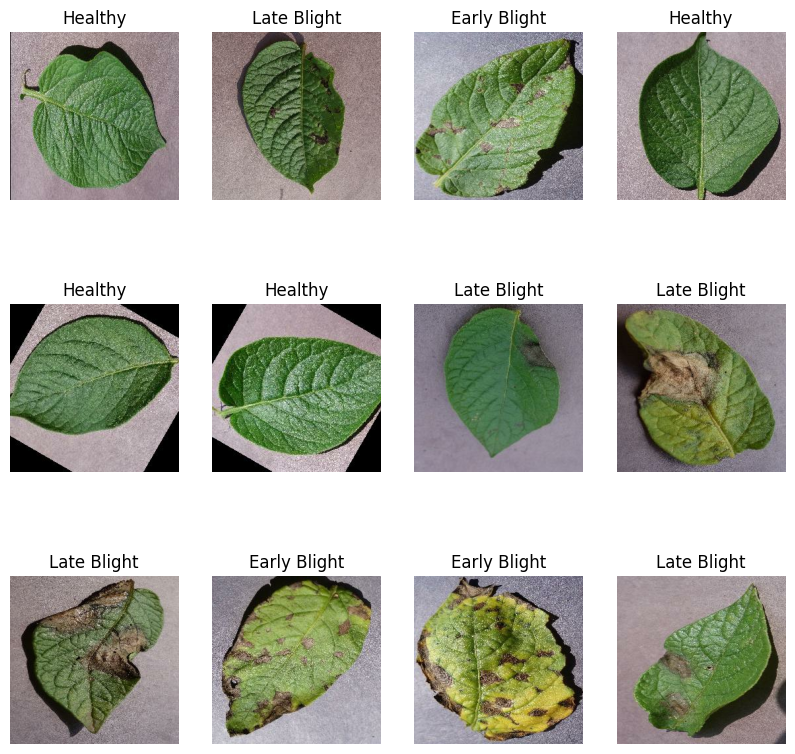

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
val_data_dir ='/content/plantvillage/Potato/Val'

val=image_dataset_from_directory(val_data_dir)

test_data_dir ='/content/plantvillage/Potato/Test'

test=image_dataset_from_directory(test_data_dir)


Found 1282 files belonging to 3 classes.
Found 144 files belonging to 3 classes.


In [8]:
import tensorflow as tf
#data pipleline
train=train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val=val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test=test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [9]:
from keras.src.engine.sequential import Sequential
#resize and rescale data
IMG_SIZE=256
EPOCHS=50
CHANNELS=3
BATCH_SIZE=32
resize_rescale = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
])

In [10]:
#augumenting train dataset
augument=Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

train = train.map(
    lambda x,y : (augument(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
#buiilding model
input_shape = ( BATCH_SIZE,IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(
    train,
    batch_size=BATCH_SIZE,
    validation_data=val,
    verbose=1,
    epochs=20,
)

Epoch 1/20
179/179 [==============================] - 72s 300ms/step - loss: 0.7345 - accuracy: 0.6585 - val_loss: 0.6189 - val_accuracy: 0.7800
Epoch 2/20
179/179 [==============================] - 54s 299ms/step - loss: 0.3563 - accuracy: 0.8588 - val_loss: 0.9039 - val_accuracy: 0.6693
Epoch 3/20
179/179 [==============================] - 52s 289ms/step - loss: 0.2421 - accuracy: 0.9044 - val_loss: 1.2860 - val_accuracy: 0.5944
Epoch 4/20
179/179 [==============================] - 52s 288ms/step - loss: 0.1417 - accuracy: 0.9493 - val_loss: 0.5453 - val_accuracy: 0.8612
Epoch 5/20
179/179 [==============================] - 52s 291ms/step - loss: 0.0781 - accuracy: 0.9700 - val_loss: 0.1082 - val_accuracy: 0.9587
Epoch 6/20
179/179 [==============================] - 52s 289ms/step - loss: 0.0747 - accuracy: 0.9747 - val_loss: 0.1229 - val_accuracy: 0.9524
Epoch 7/20
179/179 [==============================] - 52s 292ms/step - loss: 0.0537 - accuracy: 0.9835 - val_loss: 0.2077 - val_ac

In [13]:
scores = model.evaluate(test)

5/5 [==============================] - 1s 97ms/step - loss: 0.0017 - accuracy: 1.0000


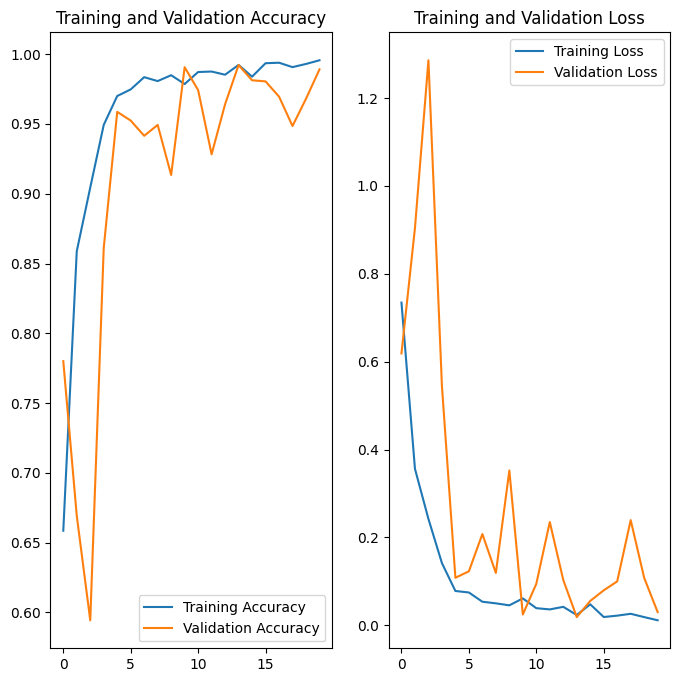

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label='Training Accuracy')
plt.plot(range(20), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Training Loss')
plt.plot(range(20), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Late Blight
1/1 [==============================] - 0s 210ms/step
predicted label: Late Blight


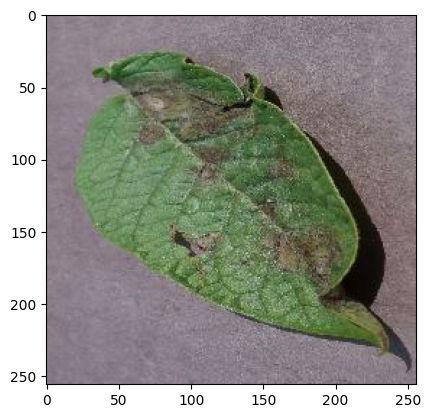

In [15]:
import numpy as np
for images_batch, labels_batch in test.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [16]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 27ms/step


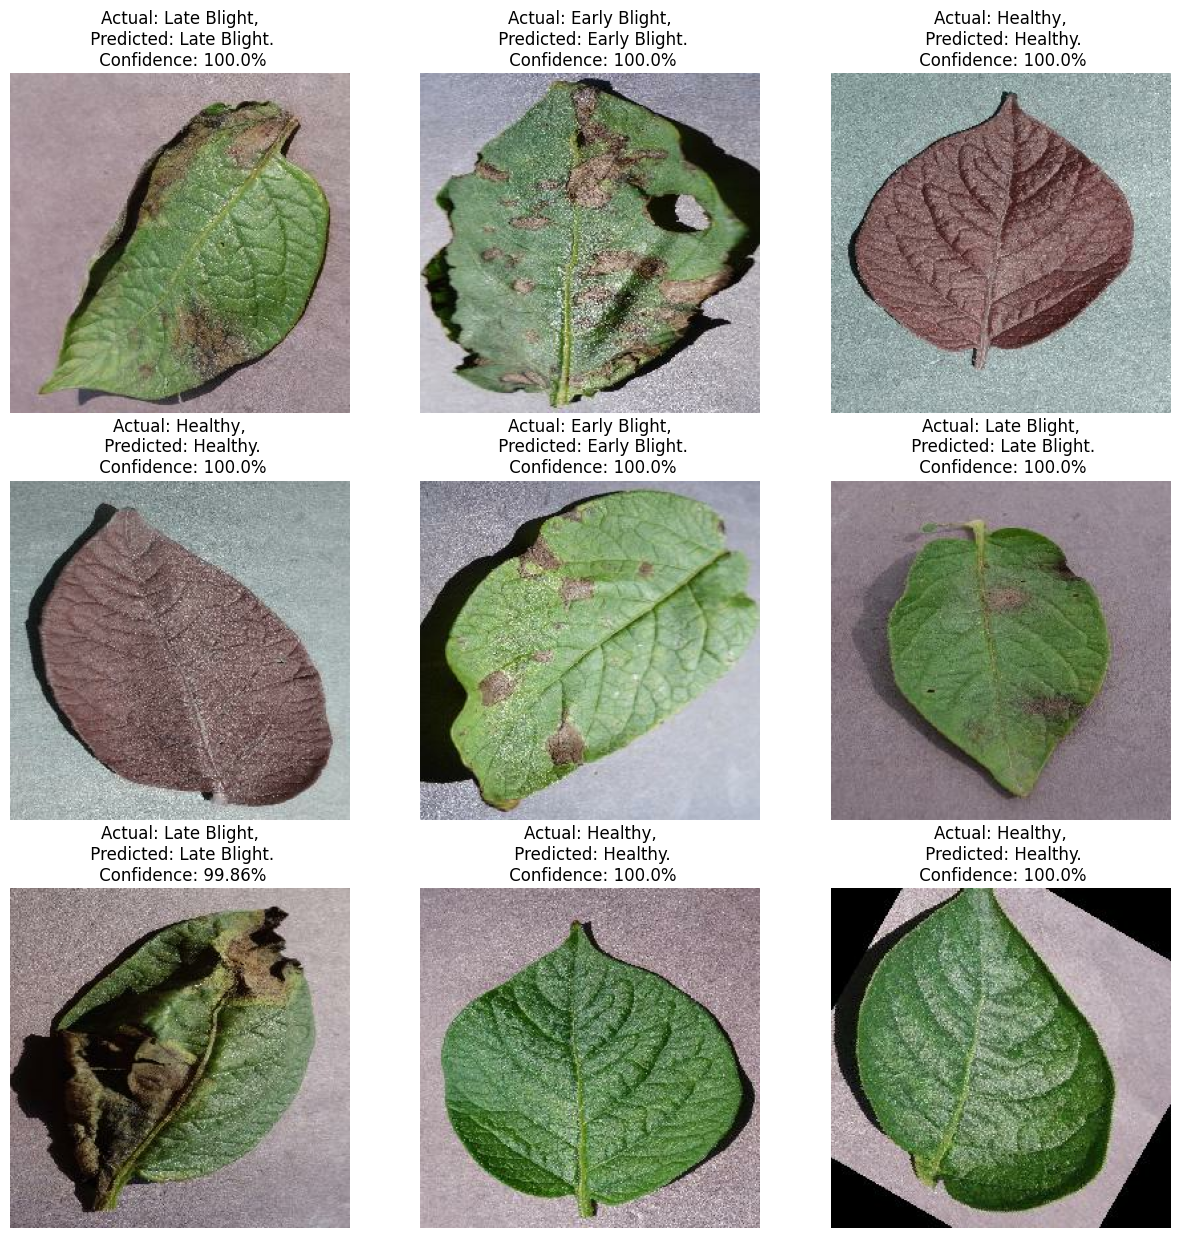

In [17]:
plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [18]:
import os

from google.colab import drive
drive.mount('/content/drive')

# Save the model to Google Drive
model.save(f'/content/drive/MyDrive/models/my_model.h5')

from google.colab import files

# Generate a download link for the model file
#files.download('/content/drive/MyDrive/models/my_model.h5')

model_json = model.to_json()
with open('/content/drive/MyDrive/models/model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# Save the model weights to an HDF5 file
model.save_weights('/content/drive/MyDrive/models/model_weights.h5')

print("Model architecture and weights saved successfully.")


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model architecture and weights saved successfully.
